https://huggingface.co/docs/transformers/model_doc/imagegpt

In [1]:
import torch
import torchvision

import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from PIL import Image

from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalImageModeling

from hybrid_transformer.evaluation.inception import InceptionV3

from hybrid_transformer.evaluation.fid import calculate_frechet_distance


%matplotlib inline

%load_ext autoreload
%autoreload 2


/home/aizdebski/micromamba/envs/hybrid-transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
BATCH_SIZE = 256

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_normalize = transforms.Compose(
     [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    

class ImageDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, path, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = self._load_images(path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample.float(), torch.Tensor([0.])
    
    @staticmethod
    def _load_images(path):
        images = np.load(path)['arr_0'].astype(np.uint8).transpose((0, 2, 3, 1))
        return images
    

def load_fid_score_model(device: torch.device) -> torch.nn.Module:
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx]).to(device)
    model = model.to(device)
    model.eval()
    return lambda batch: model(batch)[0]


@torch.no_grad()
def calculate_distribution(dataset):
    
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    distribution = []
    
    score_model = load_fid_score_model(device)
    
    for idx, batch in enumerate(loader):
        x, y = batch
        distribution.append(score_model(x.to(device)).cpu().detach().numpy())
        if idx > 10:
            break
            
    distribution_orig = np.array(np.concatenate(distribution)).reshape(-1, 2048)
    
    return distribution_orig


def plot_image_batch(imgs):
    
    imgs = [img.transpose(1, 2, 0) for img in imgs]
    
    f, axes = plt.subplots(1, len(imgs), dpi=300)
    
    for img, ax in zip(imgs, axes):
        ax.axis('off')
        ax.imshow(img)    
        

In [31]:

class ImageDataset(torchvision.datasets.VisionDataset):

    def __init__(self, root, path_to_data, transform=None, target_transform=None, feature_extractor=None):
       
        super().__init__(root=root, transform=transform, target_transform=target_transform)
        self.data = self._load_images(path_to_data)
        self.targets = np.zeros((len(self.data), ), dtype=np.float32)
        self.transform = transform
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        img = Image.fromarray(img)
        
        if self.feature_extractor is not None:
            img = self.feature_extractor(img)['input_ids'][0]
    
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
    
    @staticmethod
    def _load_images(path):
        images = np.load(path)['arr_0'].astype(np.uint8).transpose((0, 2, 3, 1))
        return images

In [7]:
test_set = torchvision.datasets.CIFAR10(
    root='data/', train=False, download=True, transform=transform)

generated_set = ImageDataset(root='data/', path_to_data='sampled.npz', transform=transform)

Files already downloaded and verified


In [90]:
test_distribution = calculate_distribution(test_set)
generated_distribution = calculate_distribution(generated_set)

In [91]:
calculate_frechet_distance(test_distribution, generated_distribution)

69.72788529698545

In [8]:
loader_test = torch.utils.data.DataLoader(
        test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
loader_generated = torch.utils.data.DataLoader(
        generated_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

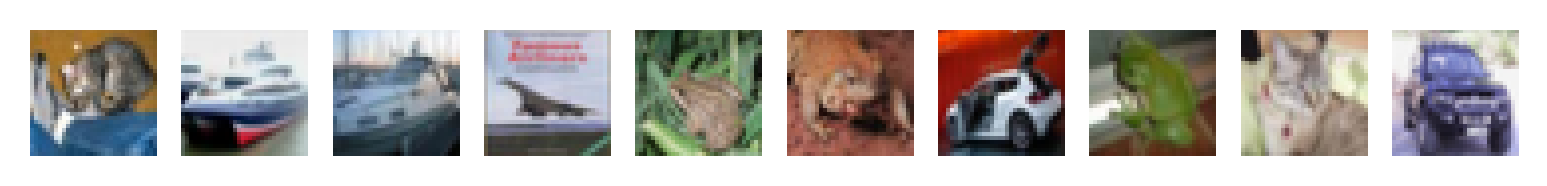

In [75]:
x, y = next(iter(loader_test))
plot_image_batch((x[:10].numpy() + 1) / 2)

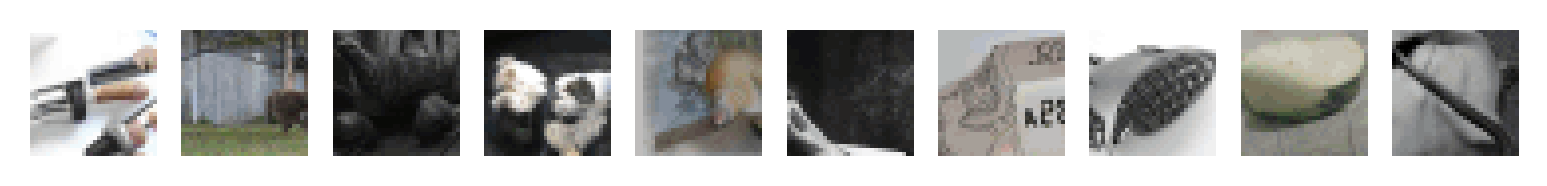

In [87]:
x, y = next(iter(loader_generated))
plot_image_batch((x[:10].numpy() + 1) / 2)

In [92]:
len(generated_set)

5479

## Finetune

In [11]:
import torch 
from datasets import load_dataset

from transformers import TrainingArguments
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalImageModeling

In [12]:
SIZE = 'small'
PRETRAINED_MODEL = f'openai/imagegpt-{SIZE}'

feature_extractor = ImageGPTFeatureExtractor.from_pretrained(PRETRAINED_MODEL)
model = ImageGPTForCausalImageModeling.from_pretrained(PRETRAINED_MODEL)

/home/aizdebski/micromamba/envs/hybrid-transformer/lib/python3.11/site-packages/transformers/models/imagegpt/feature_extraction_imagegpt.py:28: FutureWarning: The class ImageGPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ImageGPTImageProcessor instead.
  warnings.warn(


In [39]:
x.shape

torch.Size([15, 3, 32, 32])

In [35]:
generated_set = ImageDataset(root='data/', path_to_data='sampled.npz', feature_extractor=feature_extractor)
generated_loader = torch.utils.data.DataLoader(
        generated_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [36]:
x, y = generated_set[0]

In [40]:
x, y = next(iter(generated_loader))

In [44]:
output = model(input_ids=x, labels=x)

In [45]:
output.loss

tensor(1.9749, grad_fn=<NllLossBackward0>)

# Puścić na kwadratach
